In [1]:
import pandas as pd
from google.colab import drive
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

In [2]:
def load_data(filename, drive_path="/content/drive/", file_path="/content/drive/MyDrive/CapstoneProjectMcGill/Models/data/"):
  drive.mount(drive_path)
  df = pd.read_csv(f"{file_path}/{filename}")
  return df

In [3]:
def save_data(df, filename, drive_path="/content/drive/", file_path="/content/drive/MyDrive/CapstoneProjectMcGill/Models/data/"):
  drive.mount(drive_path)
  df.to_csv(f"{file_path}/{filename}", index=False)


In [4]:
df = load_data("merged_alteryx_2016_2021_with_junctions_hourly.csv")

Mounted at /content/drive/


<ipython-input-2-6b39b294774d>:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{file_path}/{filename}")


In [5]:
df.head()

,date_of_incident,grid_name,grid_area,grid_long,grid_lat,number_of_accident,rues_accdn,number_comments,number_complaints,number_requests,...,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,GridName,junctions_count
0,2016-01-01 00:00:00,Grid0_29,1.003339,-73.964095,45.437044,0,SENNEVILLE FACE,0,0,0,...,99,88,0.0,1014,-5,10,259,15,Grid0_29,2
1,2016-01-01 01:00:00,Grid0_29,1.003339,-73.964095,45.437044,0,SENNEVILLE FACE,0,0,0,...,99,89,0.0,1014,-5,10,258,15,Grid0_29,2
2,2016-01-01 02:00:00,Grid0_29,1.003339,-73.964095,45.437044,0,SENNEVILLE FACE,0,0,0,...,100,90,0.0,1014,-5,10,257,15,Grid0_29,2
3,2016-01-01 03:00:00,Grid0_29,1.003339,-73.964095,45.437044,0,SENNEVILLE FACE,0,0,0,...,100,91,0.0,1013,-5,10,256,15,Grid0_29,2
4,2016-01-01 04:00:00,Grid0_29,1.003339,-73.964095,45.437044,0,SENNEVILLE FACE,0,0,0,...,100,92,0.0,1013,-5,10,246,13,Grid0_29,2


In [6]:
# Sort values by grin_name and date to get the data by the grid ordered by date so that
# We can take the running sum
df.sort_values(["grid_name", "date_of_incident"], inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28185024 entries, 0 to 28185023
Data columns (total 29 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date_of_incident    object 
 1   grid_name           object 
 2   grid_area           float64
 3   grid_long           float64
 4   grid_lat            float64
 5   number_of_accident  int64  
 6   rues_accdn          object 
 7   number_comments     int64  
 8   number_complaints   int64  
 9   number_requests     int64  
 10  maxtempC            int64  
 11  mintempC            int64  
 12  totalSnow_cm        float64
 13  moon_illumination   int64  
 14  DewPointC           int64  
 15  FeelsLikeC          int64  
 16  HeatIndexC          int64  
 17  WindChillC          int64  
 18  WindGustKmph        int64  
 19  cloudcover          int64  
 20  humidity            int64  
 21  precipMM            float64
 22  pressure            int64  
 23  tempC               int64  
 24  visibility          in

In [8]:
len(df[df.number_of_accident > 0])

106761

In [9]:
# Add the categorical column for day, month and weekend

# Convert 'day_of_incident' column to datetime format
df['date_of_incident'] = pd.to_datetime(df['date_of_incident'])


In [10]:

# Extract day of the week (Monday=0, Sunday=6)
df['day_of_week'] = df['date_of_incident'].dt.dayofweek
df['hour_of_day'] = df['date_of_incident'].dt.hour
# Extract month (January=1, December=12)
df['month'] = df['date_of_incident'].dt.month

# Create a new column indicating weekdays (0) or weekends (1)
#df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


In [11]:
def running_sum(df: pd.DataFrame, group_by_col: str, running_sum_cols: list, window: int=7) -> pd.DataFrame:
  """
  Find the running sum of data by group col for running sum cols
  """

  for col in running_sum_cols:
    df[f"rolling_sum_{col}"] = df.groupby(group_by_col)[col].rolling(min_periods=1, window=window).sum().reset_index(level=0, drop=True)
  return df


In [12]:
df = running_sum(df, "grid_name", ["number_comments", "number_complaints", "number_requests"], window=7)

In [13]:
df["date_accdn"] = df["date_of_incident"].dt.date


In [14]:
df["number_of_accident_hour"] = df["number_of_accident"]

In [15]:
accident_per_day_per_grid = df.groupby(["date_accdn", "grid_name"])["number_of_accident_hour"].sum()

In [16]:
# Merge the data per day
df = df.merge(accident_per_day_per_grid, on=['date_accdn', 'grid_name'], how='left')

In [17]:
df.columns

Index(['date_of_incident', 'grid_name', 'grid_area', 'grid_long', 'grid_lat',
       'number_of_accident', 'rues_accdn', 'number_comments',
       'number_complaints', 'number_requests', 'maxtempC', 'mintempC',
       'totalSnow_cm', 'moon_illumination', 'DewPointC', 'FeelsLikeC',
       'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity',
       'precipMM', 'pressure', 'tempC', 'visibility', 'winddirDegree',
       'windspeedKmph', 'GridName', 'junctions_count', 'day_of_week',
       'hour_of_day', 'month', 'rolling_sum_number_comments',
       'rolling_sum_number_complaints', 'rolling_sum_number_requests',
       'date_accdn', 'number_of_accident_hour_x', 'number_of_accident_hour_y'],
      dtype='object')

In [18]:
#df.drop("total_accident_day", axis=1, inplace=True)
df["number_of_accident_day"] = df["number_of_accident_hour_y"]
df["number_of_accident_hour"] = df["number_of_accident_hour_x"]
df.drop(["number_of_accident", "number_of_accident_hour_x", "number_of_accident_hour_y"], axis=1, inplace=True)

In [19]:
accident_per_day_df = accident_per_day_per_grid.reset_index()
accident_per_day_df.head()

,date_accdn,grid_name,number_of_accident_hour
0,2016-01-01,Grid0_29,0
1,2016-01-01,Grid0_30,0
2,2016-01-01,Grid0_31,0
3,2016-01-01,Grid0_32,0
4,2016-01-01,Grid10_20,0


In [20]:
accident_per_day_df.sort_values(["grid_name", "date_accdn"], inplace=True)
accident_per_day_df.head()

,date_accdn,grid_name,number_of_accident_hour
0,2016-01-01,Grid0_29,0
536,2016-01-02,Grid0_29,0
1072,2016-01-03,Grid0_29,0
1608,2016-01-04,Grid0_29,0
2144,2016-01-05,Grid0_29,0


In [21]:
def running_sum_exclude_current_day(df: pd.DataFrame, group_by_col: str, running_sum_cols: list, window: int=7) -> pd.DataFrame:
  """
  Find the running sum of data by group col for running sum cols
  """

  for col in running_sum_cols:
    df[f"shifted_{col}"] = df.groupby(group_by_col)[col].shift().fillna(0)
    df[f"rolling_sum_{col}"] = df.groupby(group_by_col)[f"shifted_{col}"].rolling(min_periods=1, window=window).sum().reset_index(level=0, drop=True)
  return df
accident_per_day_df = running_sum_exclude_current_day(accident_per_day_df, "grid_name", ["number_of_accident_hour"], window=7)

In [22]:
accident_per_day_df[accident_per_day_df["grid_name"] == "Grid8_26"]

,date_accdn,grid_name,number_of_accident_hour,shifted_number_of_accident_hour,rolling_sum_number_of_accident_hour
520,2016-01-01,Grid8_26,0,0.0,0.0
1056,2016-01-02,Grid8_26,0,0.0,0.0
1592,2016-01-03,Grid8_26,0,0.0,0.0
2128,2016-01-04,Grid8_26,0,0.0,0.0
2664,2016-01-05,Grid8_26,0,0.0,0.0
...,...,...,...,...,...
1172216,2021-12-26,Grid8_26,0,0.0,0.0
1172752,2021-12-27,Grid8_26,0,0.0,0.0
1173288,2021-12-28,Grid8_26,0,0.0,0.0
1173824,2021-12-29,Grid8_26,0,0.0,0.0


In [23]:
accident_per_day_df.drop(labels=["number_of_accident_hour","shifted_number_of_accident_hour"], axis=1, inplace=True)

In [24]:
df = df.merge(accident_per_day_df, on=['date_accdn', 'grid_name'], how='left')

In [25]:
df[df["grid_name"] == "Grid8_26"][["date_of_incident", "grid_name", "number_of_accident_hour", "rolling_sum_number_of_accident_hour"]]

,date_of_incident,grid_name,number_of_accident_hour,rolling_sum_number_of_accident_hour
27343680,2016-01-01 00:00:00,Grid8_26,0,0.0
27343681,2016-01-01 01:00:00,Grid8_26,0,0.0
27343682,2016-01-01 02:00:00,Grid8_26,0,0.0
27343683,2016-01-01 03:00:00,Grid8_26,0,0.0
27343684,2016-01-01 04:00:00,Grid8_26,0,0.0
...,...,...,...,...
27396259,2021-12-30 19:00:00,Grid8_26,0,0.0
27396260,2021-12-30 20:00:00,Grid8_26,0,0.0
27396261,2021-12-30 21:00:00,Grid8_26,0,0.0
27396262,2021-12-30 22:00:00,Grid8_26,0,0.0


In [28]:
df.head()

,date_of_incident,grid_name,grid_area,grid_long,grid_lat,rues_accdn,number_comments,number_complaints,number_requests,maxtempC,...,day_of_week,hour_of_day,month,rolling_sum_number_comments,rolling_sum_number_complaints,rolling_sum_number_requests,date_accdn,number_of_accident_day,number_of_accident_hour,rolling_sum_number_of_accident_day
0,2016-01-01 00:00:00,Grid0_29,1.003339,-73.964095,45.437044,SENNEVILLE FACE,0,0,0,-1,...,4,0,1,0.0,0.0,0.0,2016-01-01,0,0,0.0
1,2016-01-01 01:00:00,Grid0_29,1.003339,-73.964095,45.437044,SENNEVILLE FACE,0,0,0,-1,...,4,1,1,0.0,0.0,0.0,2016-01-01,0,0,0.0
2,2016-01-01 02:00:00,Grid0_29,1.003339,-73.964095,45.437044,SENNEVILLE FACE,0,0,0,-1,...,4,2,1,0.0,0.0,0.0,2016-01-01,0,0,0.0
3,2016-01-01 03:00:00,Grid0_29,1.003339,-73.964095,45.437044,SENNEVILLE FACE,0,0,0,-1,...,4,3,1,0.0,0.0,0.0,2016-01-01,0,0,0.0
4,2016-01-01 04:00:00,Grid0_29,1.003339,-73.964095,45.437044,SENNEVILLE FACE,0,0,0,-1,...,4,4,1,0.0,0.0,0.0,2016-01-01,0,0,0.0


In [30]:
#df["rolling_sum_number_of_accident_day"] = df["rolling_sum_number_of_accident_hour"]
#df.drop(labels=["rolling_sum_number_of_accident_hour"], axis=1, inplace=True)
df.columns

Index(['date_of_incident', 'grid_name', 'grid_area', 'grid_long', 'grid_lat',
       'rues_accdn', 'number_comments', 'number_complaints', 'number_requests',
       'maxtempC', 'mintempC', 'totalSnow_cm', 'moon_illumination',
       'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph',
       'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility',
       'winddirDegree', 'windspeedKmph', 'GridName', 'junctions_count',
       'day_of_week', 'hour_of_day', 'month', 'rolling_sum_number_comments',
       'rolling_sum_number_complaints', 'rolling_sum_number_requests',
       'date_accdn', 'number_of_accident_day', 'number_of_accident_hour',
       'rolling_sum_number_of_accident_day'],
      dtype='object')

In [31]:
# Lets find correlation between data exclude that has high correlation
numerical_indepent_variables = [
    'rolling_sum_number_comments',
    'rolling_sum_number_complaints',
    'rolling_sum_number_requests',
    'junctions_count',
    "number_of_accident_day",
    "number_of_accident_hour",
    'rolling_sum_number_of_accident_day']


In [32]:
correlation_matrix = df[numerical_indepent_variables].corr()
correlation_matrix

,rolling_sum_number_comments,rolling_sum_number_complaints,rolling_sum_number_requests,junctions_count,number_of_accident_day,number_of_accident_hour,rolling_sum_number_of_accident_day
rolling_sum_number_comments,1.000000,0.163498,0.128785,0.075515,0.032700,0.007380,0.055679
rolling_sum_number_complaints,0.163498,1.000000,0.180238,0.108947,0.050688,0.011223,0.091483
rolling_sum_number_requests,0.128785,0.180238,1.000000,0.360523,0.150719,0.033490,0.267008
junctions_count,0.075515,0.108947,0.360523,1.000000,0.221766,0.048677,0.441251
number_of_accident_day,0.032700,0.050688,0.150719,0.221766,1.000000,0.219496,0.253680
number_of_accident_hour,0.007380,0.011223,0.033490,0.048677,0.219496,1.000000,0.055682
rolling_sum_number_of_accident_day,0.055679,0.091483,0.267008,0.441251,0.253680,0.055682,1.000000


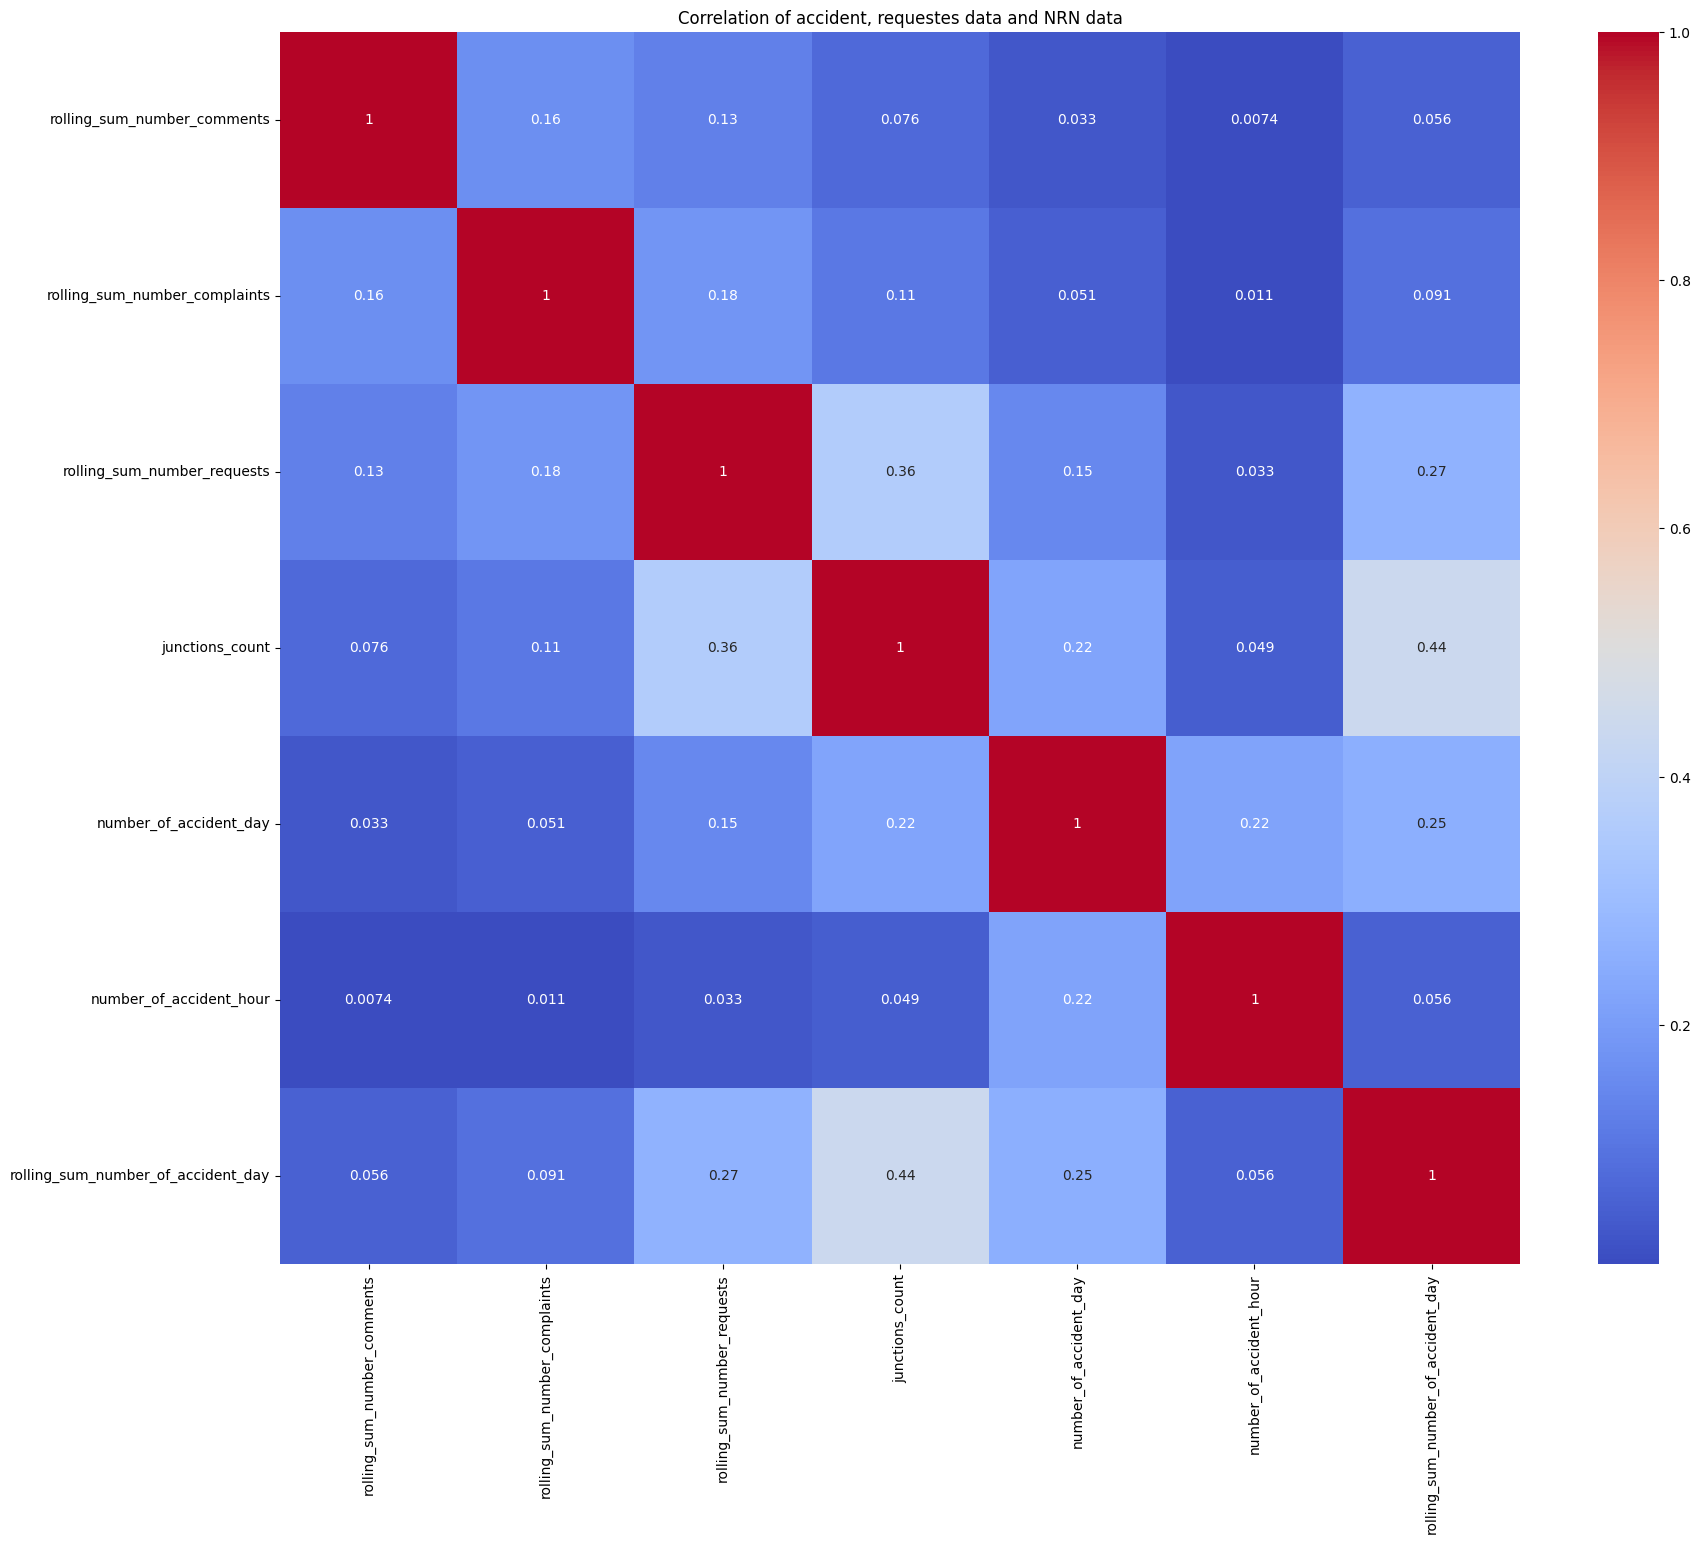

In [33]:
# Correlation heat map
plt.figure(figsize=(20, 16))  # Set the size of the heatmap figure

# Customize the heatmap appearance using seaborn
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)

# Add a title
plt.title('Correlation of accident, requestes data and NRN data')

# Display the heatmap
plt.show()


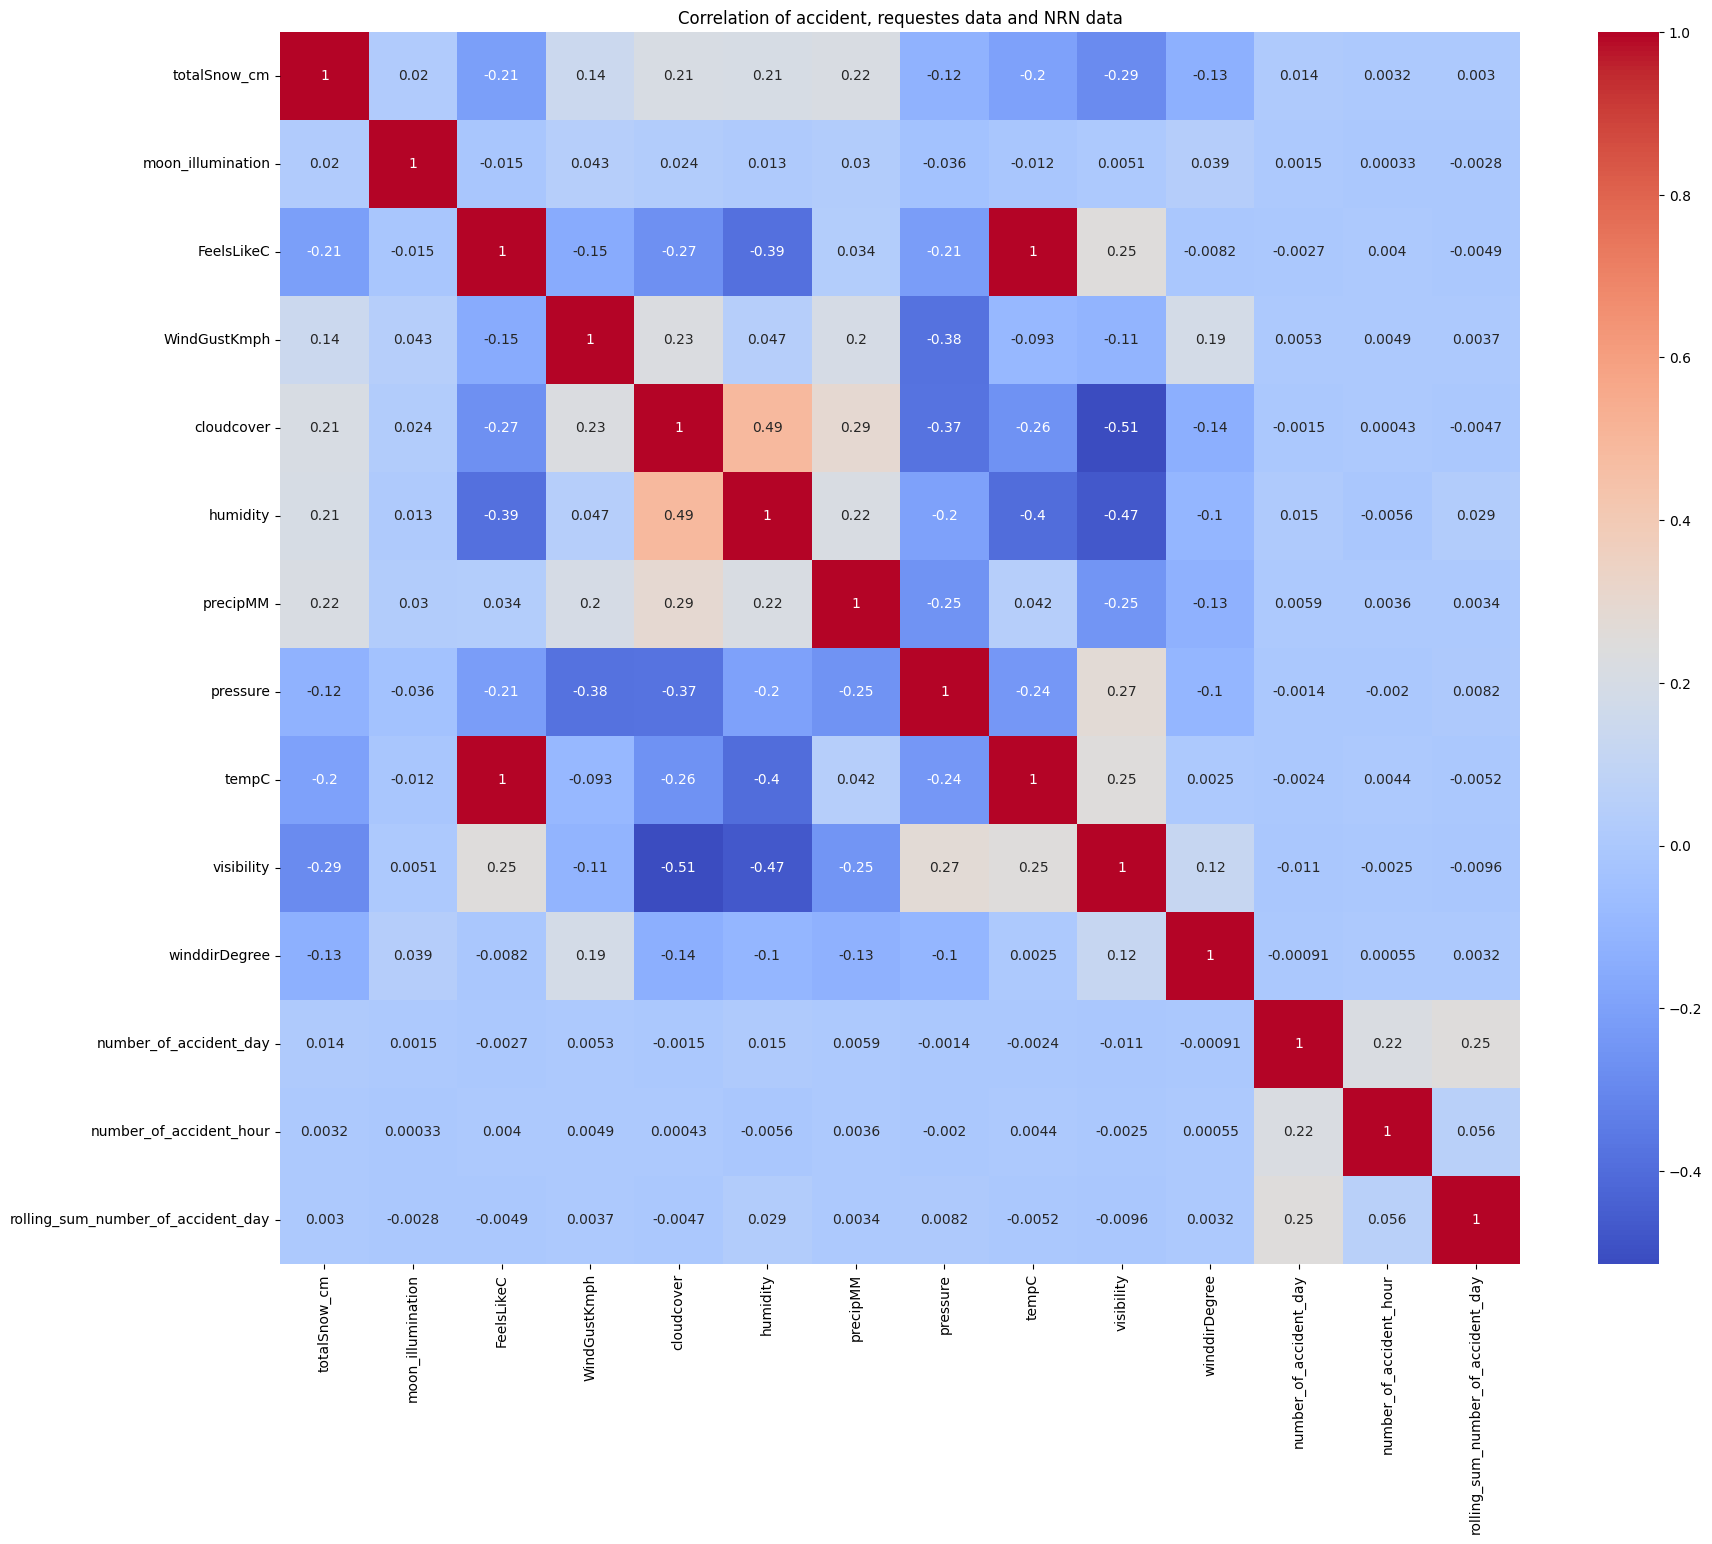

In [34]:

weather_data = [
    'totalSnow_cm',
    'moon_illumination',
    'FeelsLikeC',
    'WindGustKmph',
    'cloudcover',
    'humidity',
    'precipMM',
    'pressure',
    'tempC',
    'visibility',
    'winddirDegree',
    "number_of_accident_day",
    "number_of_accident_hour",
    'rolling_sum_number_of_accident_day']
correlation_matrix = df[weather_data].corr()
correlation_matrix

# Correlation heat map
plt.figure(figsize=(20, 16))  # Set the size of the heatmap figure

# Customize the heatmap appearance using seaborn
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)

# Add a title
plt.title('Correlation of accident, requestes data and NRN data')

# Display the heatmap
plt.show()


In [ ]:
# From above heatmap we found out that following are correlated

# 'number_comments => rolling_sum_number_comments
# 'number_complaints => rolling_sum_number_complaints
# 'number_requests => rolling_sum_number_requests

# tempc correlated with maxTempC , minTempc , DewpointC , 'FeelsLikeC',  'HeatIndexC',  'WindChillC'
# windGustKmph => windSpeedKmph

# Just select tempc and windGustKmph rolling_sum_number_comments, rolling_sum_number_complaints, rolling_sum_number_requests

In [35]:
df.columns

Index(['date_of_incident', 'grid_name', 'grid_area', 'grid_long', 'grid_lat',
       'rues_accdn', 'number_comments', 'number_complaints', 'number_requests',
       'maxtempC', 'mintempC', 'totalSnow_cm', 'moon_illumination',
       'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph',
       'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility',
       'winddirDegree', 'windspeedKmph', 'GridName', 'junctions_count',
       'day_of_week', 'hour_of_day', 'month', 'rolling_sum_number_comments',
       'rolling_sum_number_complaints', 'rolling_sum_number_requests',
       'date_accdn', 'number_of_accident_day', 'number_of_accident_hour',
       'rolling_sum_number_of_accident_day'],
      dtype='object')

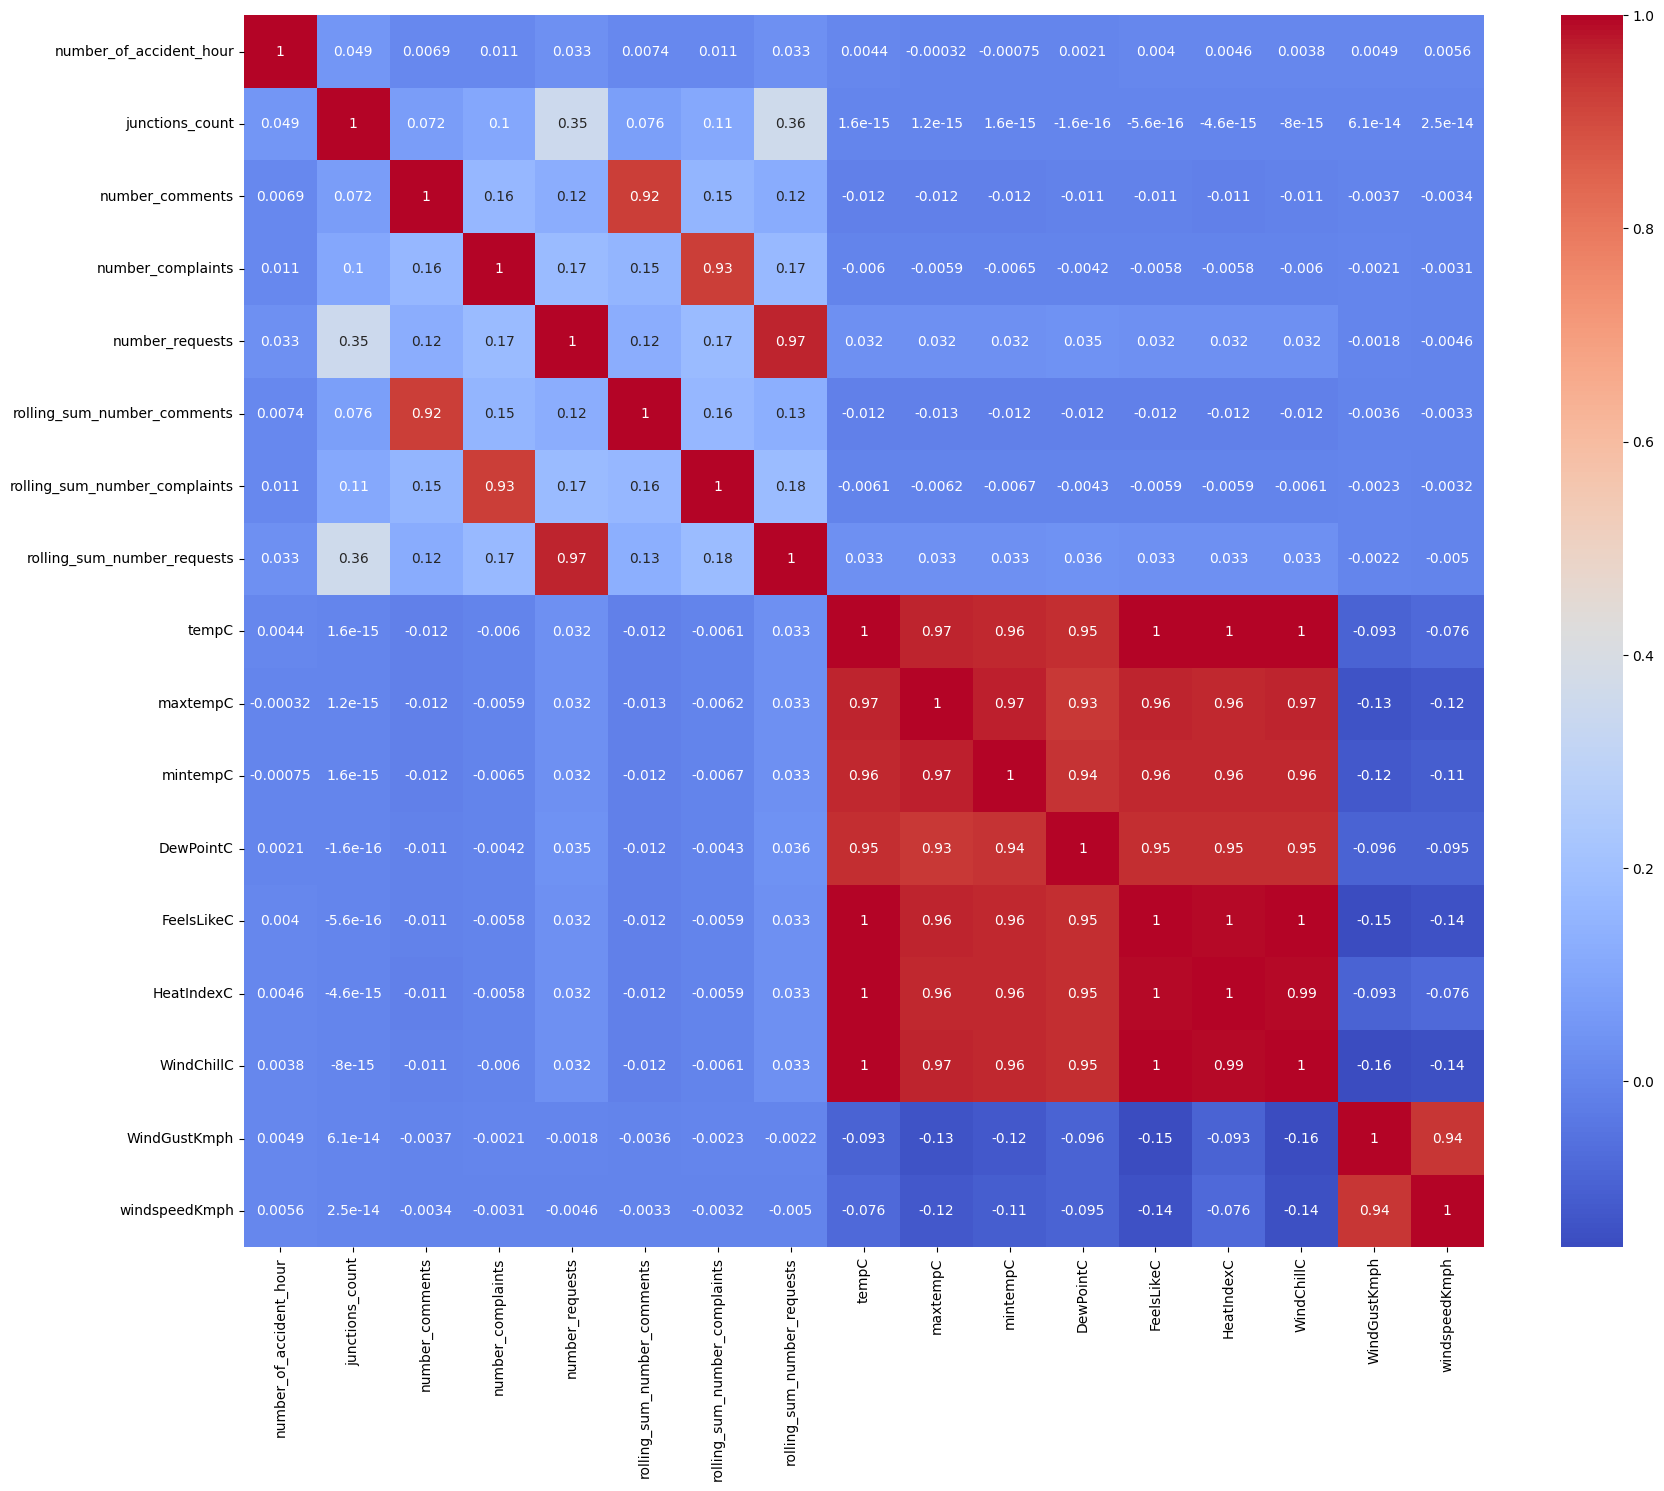

In [36]:
# Lets find number_of_accidents have high correlation with what variables that we want to exclude
cols = [
    "number_of_accident_hour",
    'junctions_count',
    'number_comments',
    'number_complaints',
    'number_requests',
    'rolling_sum_number_comments',
    'rolling_sum_number_complaints',
    'rolling_sum_number_requests',
    'tempC',
    'maxtempC',
    'mintempC',
    'DewPointC',
    'FeelsLikeC',
    'HeatIndexC',
    'WindChillC',
    'WindGustKmph',
    'windspeedKmph',
]

correlated_with_accidents = df[cols].corr()
# Correlation heat map
plt.figure(figsize=(20, 16))  # Set the size of the heatmap figure

# Customize the heatmap appearance using seaborn
sns.heatmap(correlated_with_accidents, cmap='coolwarm', annot=True)

# Add a title
plt.title('')

# Display the heatmap
plt.show()


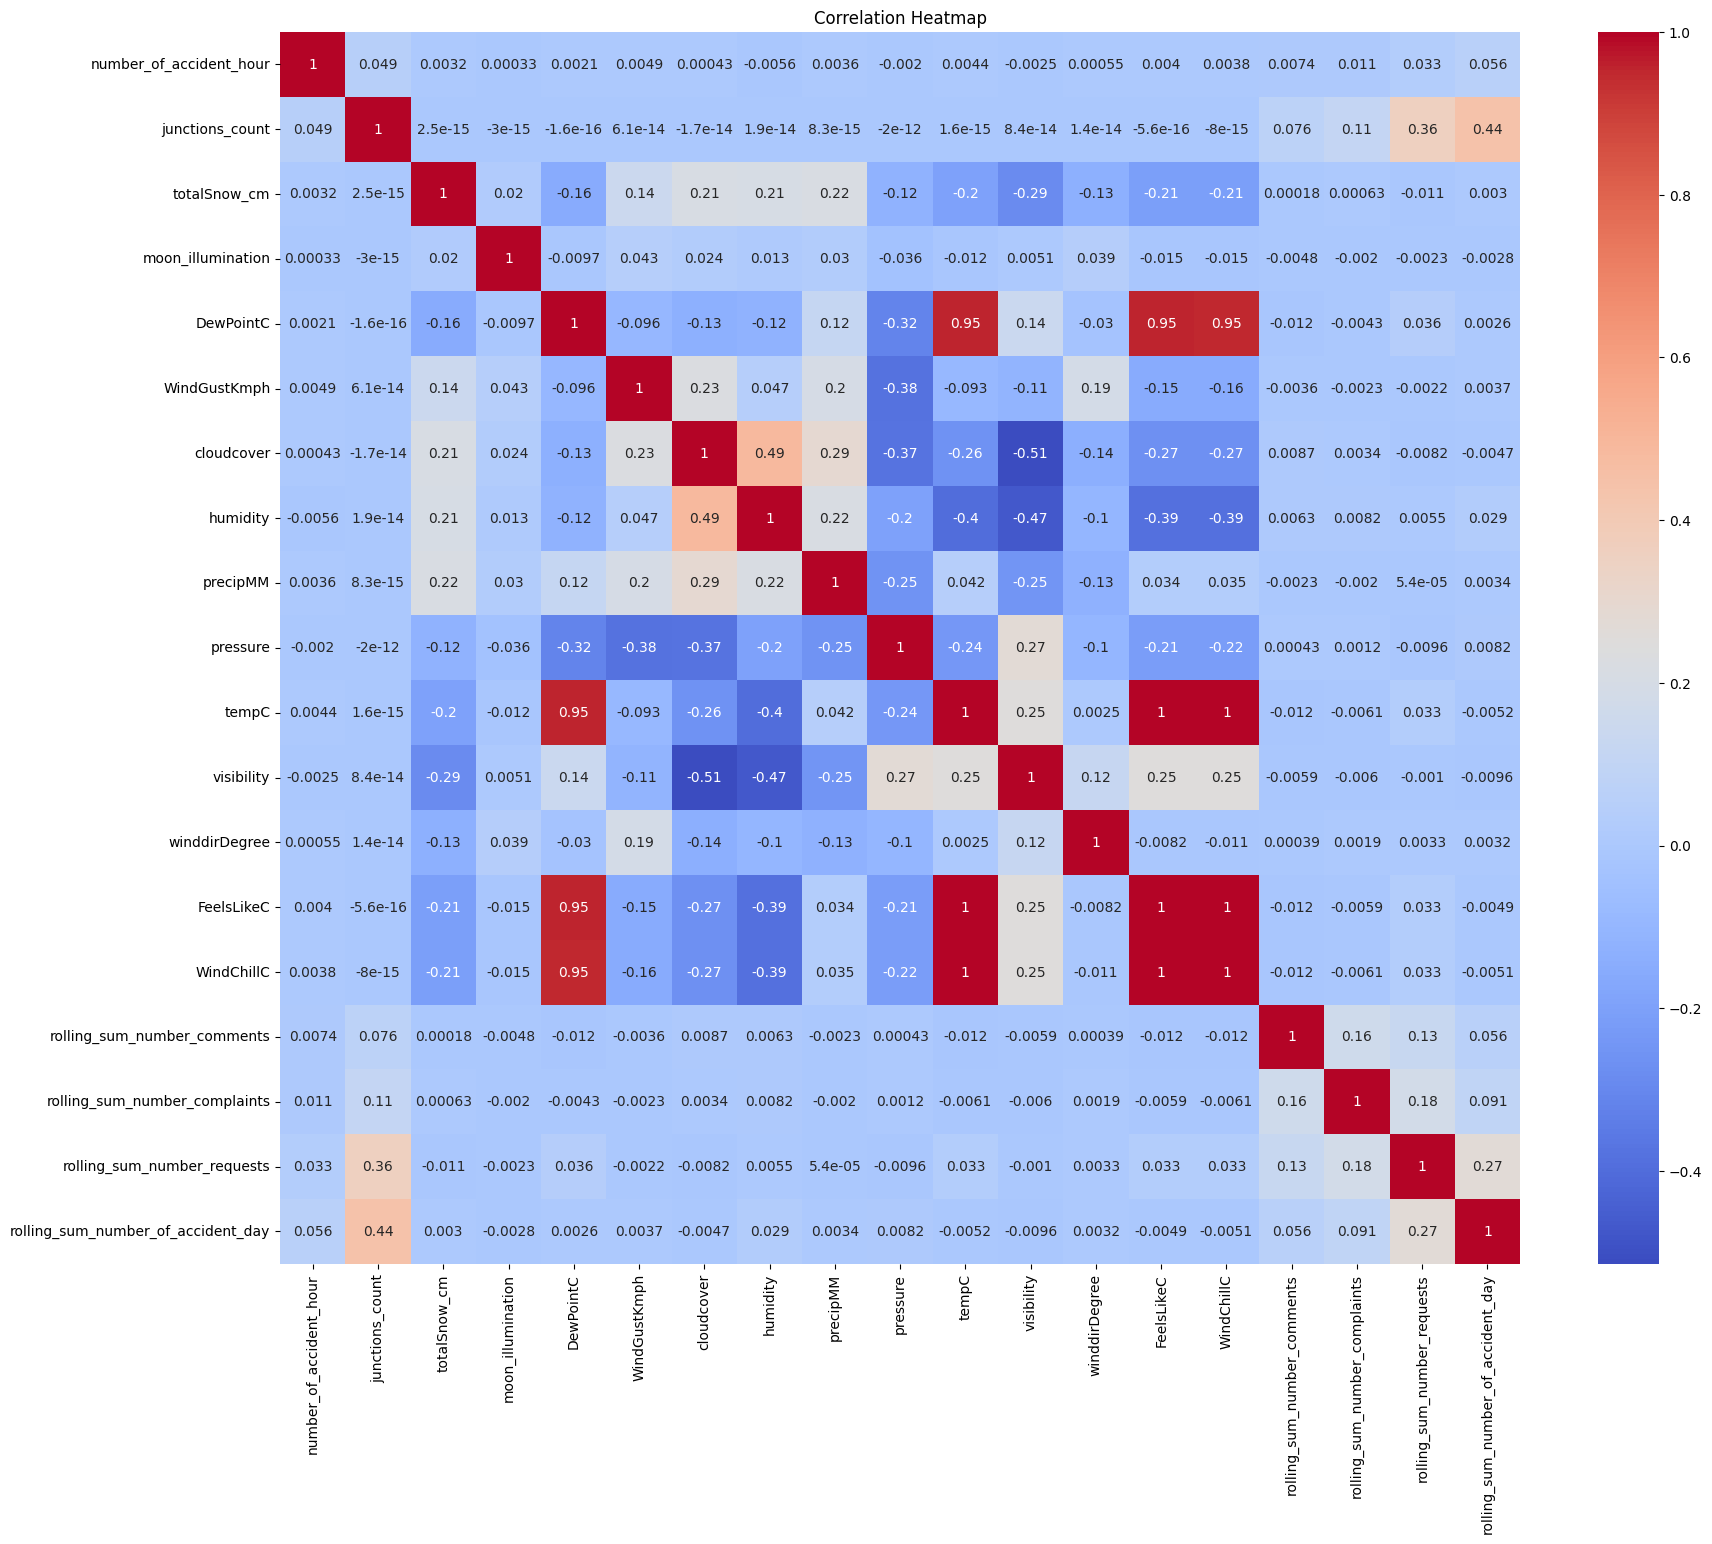

In [38]:
# From above heatmap it looks like number_of_accident have the higher correlation with rolling sum of calls compared to call on the day.
# number_of_accident have higher correlation to tempC compared to 'maxtempC', 'mintempC', 'DewPointC', 'HeatIndexC'
# number_of_accident have highter correlation with windGustKMph compared to windspeedKmph

selected_predictors = [
    'number_of_accident_hour',
    'junctions_count',
    'totalSnow_cm',
    'moon_illumination',
    'DewPointC',
    'WindGustKmph',
    'cloudcover',
    'humidity',
    'precipMM',
    'pressure',
    'tempC',
    'visibility',
    'winddirDegree',
    'FeelsLikeC',
    'WindChillC',
    'rolling_sum_number_comments',
    'rolling_sum_number_complaints',
    'rolling_sum_number_requests',
    'rolling_sum_number_of_accident_day']

#Lets find the correlation now
final_correlation = df[selected_predictors].corr()
# Correlation heat map
plt.figure(figsize=(20, 16))  # Set the size of the heatmap figure

# Customize the heatmap appearance using seaborn
sns.heatmap(final_correlation, cmap='coolwarm', annot=True)

# Add a title
plt.title('Correlation Heatmap')

# Display the heatmap
plt.show()

In [39]:
df['has_accident'] = np.where(df['number_of_accident_hour'] > 0, 1, 0)

In [40]:
selected_columns = [
    'date_of_incident',
    'grid_name',
    'grid_area',
    'grid_long',
    'grid_lat',
    'rues_accdn',
    'totalSnow_cm',
    'moon_illumination',
    'WindChillC',
    'cloudcover',
    'humidity',
    'precipMM',
    'pressure',
    'tempC',
    'visibility',
    'winddirDegree',
    'windspeedKmph',
    'junctions_count',
    'day_of_week',
    'hour_of_day',
    'month',
    'rolling_sum_number_comments',
    'rolling_sum_number_complaints',
    'rolling_sum_number_requests',
    'number_of_accident_day',
    'number_of_accident_hour',
    'rolling_sum_number_of_accident_day',
    'has_accident'
]

df2 = df[selected_columns]

In [ ]:
save_data(df, "minimized_data.csv")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [42]:
# Lets only select the negative(no accident) data equal to number of accident data.
# To make the data balanced for each grid.
grids = df2["grid_name"].unique()
df3 = pd.DataFrame()
for grid in grids:
  positive_data = df2[(df2["grid_name"] == grid) & (df2["has_accident"] > 0) ]
  number_of_positives = len(positive_data)
  negative_rows = df2[(df2["grid_name"] == grid) & (df2["has_accident"] == 0) & (df2["rolling_sum_number_of_accident_day"] == 0)]
  if len(negative_rows) > number_of_positives:
    negative_rows = negative_rows.sample(n=number_of_positives, random_state=3)
  df3 = pd.concat([df3, positive_data, negative_rows], axis=0)

In [45]:
save_data(df3, "wrangled_data_balanced_july4th.csv")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# The end of new data wrangle.

In [43]:
len(df3[df3["has_accident"] == 0])

106761

In [44]:
len(df3[df3["has_accident"] == 1])

106761